# Sequential Learning

- Batch tecniques (e.g MLE) that processing all data at once, can be computational cost.
- Sequential learning(a.k.a. On-line learning) considers data one-by-one
- This can be done by SGD algorithm:
$$W^{\tau+1} = W^{\tau} - \eta\nabla E_{n} = W^{\tau} + \eta\;(y_{n} - w^{\tau}\phi_{n})\;\phi_{n}$$

, where $\eta$ is learning rate, $W$ is initialized by $W^{0}$, $E_{n}$ is the MSE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from PIL import Image

warnings.filterwarnings('ignore')
%matplotlib inline

#### Generate data

In [2]:
def simulator(f, sample_size, std, l=0, h=1):
    x = np.linspace(l, h, sample_size)
    noise = np.random.normal(scale=std, size=x.shape)
    t = f(x) + noise
    return x.reshape(sample_size, -1), t

def f(x):
    return np.sin(2 * np.pi * x)

# generate data
def genrate_data(N_tr=10, N_ts=100, std=0.3, l=0, h=1):
    x_train, y_train = simulator(f, N_tr, std, l=l, h=h)
    x_test = np.linspace(l, h, N_ts)
    y_test = f(x_test)
    return x_train.reshape(N_tr, -1), y_train, x_test.reshape(N_ts, -1), y_test

#### Plot results

In [3]:
def plot_results(X_tr, y_tr, X_ts, y_ts, pred, ax, title=None, text=None):
    ax.scatter(X_tr, y_tr, facecolor="none", edgecolor="b", s=50, label="training data")
    ax.plot(X_ts, pred, 'r', label='Regression line')
    ax.plot(X_ts, y_ts, c='g', label="$\sin(2\pi x)$")
    ax.set_xlabel('$X$', size=15)
    ax.set_ylabel('$Y$', rotation=0, size=15)
    if title:
        ax.set_title(title, fontsize=16)
    if text:
        ax.set_ylim(-1.6, 2)
        ax.text(0, 1.7, text, size=20)
    ax.legend()
    return ax

#### Training class

In [4]:
class Sequential:
    def __init__(self, batch_size, num_epochs, lr, transform='Gauss', mu=None, 
                 s=None, degree=None, animate_path='temp_gif'):
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.transform = transform
        self.s = s
        self.degree = degree
        self.animate_path = animate_path
        if isinstance(mu, int):
            mu = [mu]    
        self.mu = mu
        try:
            os.mkdir(self.animate_path)
        except:
            pass

    def _transform(self, X):
        
        X_trans = X.copy() 
        
        if self.transform.lower()=='gauss':
            for m in self.mu:
                X_trans = np.append(X_trans, np.exp(-0.5 * np.square(X - m)/self.s), axis=1)

        if self.transform.lower()=='ploy':
            for i in range(2, self.degrees+2):
                X_trans = np.append(X_trans, X**i, axis=1)

        if self.transform.lower()=='sig':
            for m in self.mu:
                X_trans = np.append(X_trans, (np.tanh((X - m) / self.s) + 1 ) / 2, axis=1)

        return np.array(X_trans).reshape(X.shape[0], -1)
        
    # Loss function En
    def loss(self, y, y_hat):
            return np.mean((y_hat - y)**2)

    # Gradients of loss function w.r.t W, b
    def gradients(self, X, y, y_hat):
        dw = (1/self.N)*np.dot(X.T, (y_hat - y)) 
        db = (1/self.N)*np.sum((y_hat - y)) 
        return dw, db

    # to animate the training process
    def create_frame(self, X_tr, y_tr, X_ts, y_ts, n_ep):
        y_pred = self.predict(self.X_ts)
        _, ax = plt.subplots(figsize=(10, 6))
        plot_results(X_tr, y_tr, X_ts, y_ts, y_pred, ax, 'Epoch %d'%(n_ep+1))
        plt.savefig('temp_gif/img_%d.png'%n_ep)
        frame = Image.open('temp_gif/img_%d.png'%n_ep)
        return frame
    
    def fit(self, X, y, X_ts, y_ts):
        self.X_ts = X_ts
        self.y_ts = y_ts
        # transform data
        X_trans = self._transform(X)
        X_ts_trans = self._transform(X_ts)
        y = y.reshape(-1, 1)

        # number of training examples, number of features
        self.N, self.P = X_trans.shape

        # Initialize W, b
        self.W = np.zeros((self.P,1))
        self.b = 0
        
        # track training process
        self.history = {}
        frames = []
                
        ############
        # Training #
        ############
        for epoch in range(self.num_epochs):
            for i in range((self.N-1)//self.batch_size + 1):

                # Defining batches.
                start_i = i*self.batch_size
                end_i = start_i + self.batch_size
                xb = X_trans[start_i:end_i]
                yb = y[start_i:end_i]

                # make a prediction
                y_hat = np.dot(xb, self.W) + self.b

                # Calculating the gradients of loss
                dW, db = self.gradients(xb, yb, y_hat)

                # Updating the parameters.
                self.W -= self.lr*dW
                self.b -= self.lr*db

            self.history[epoch] = self.loss(y, np.dot(X_trans, self.W) + self.b)
            frames.append(self.create_frame(X, y, X_ts, y_ts, epoch))
        
        frames[0].save('training_animation.gif', format='GIF',
                       append_images=frames[1:],
                       save_all=True,
                       duration=250, loop=200) 

    ##############
    # Prediction #
    ##############
    def predict(self, X):
        
        X_ = self._transform(X)
    
        return X_ @ self.W + self.b

In [5]:
d = 10
X_train, y_train, X_test, y_test = genrate_data(N_tr=100, l=0, h=1)

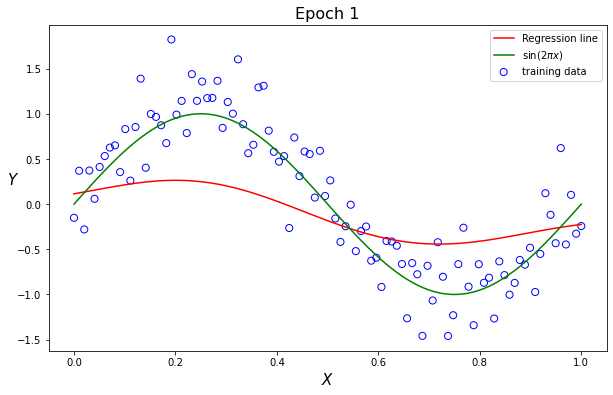

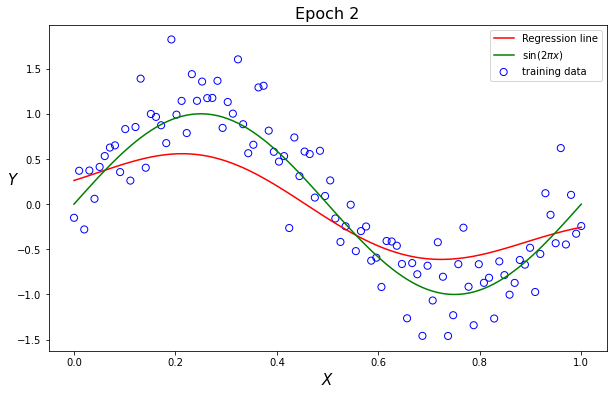

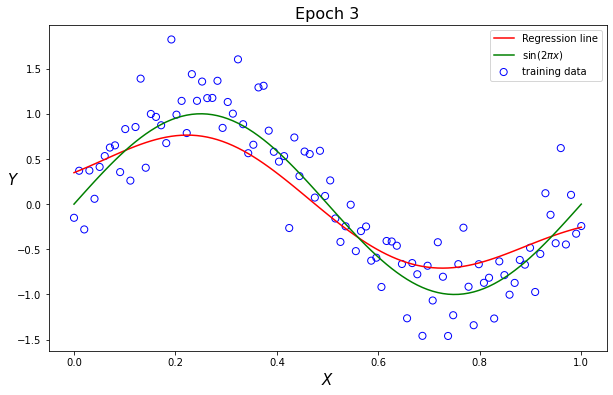

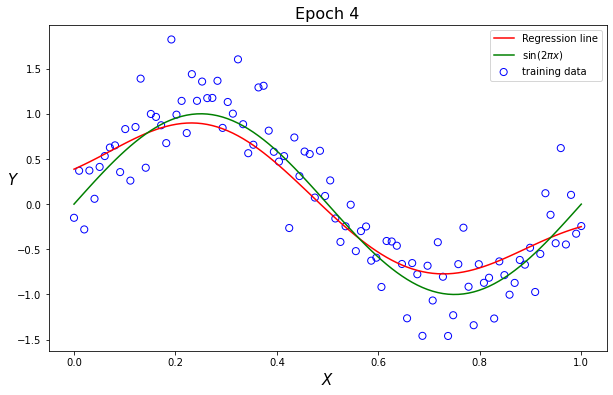

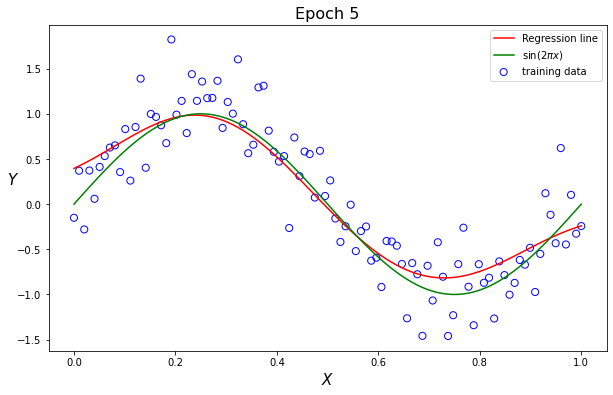

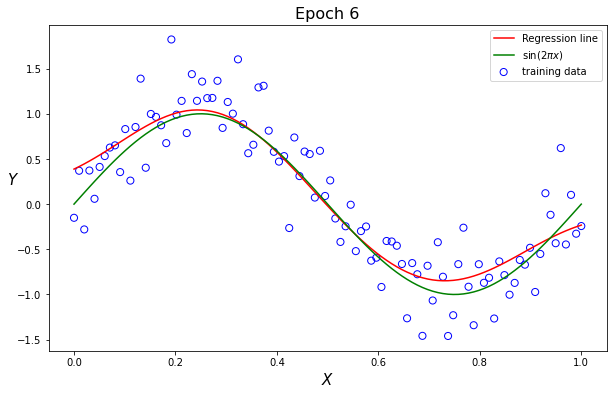

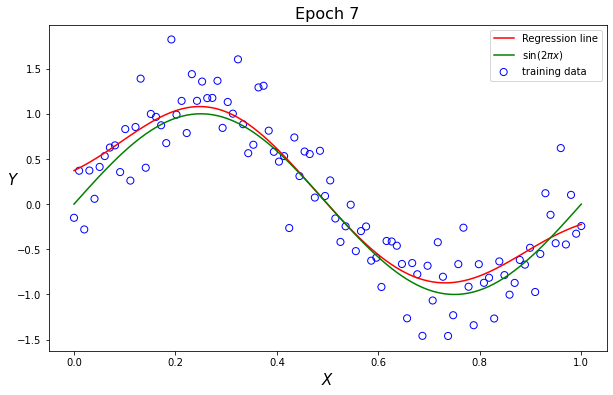

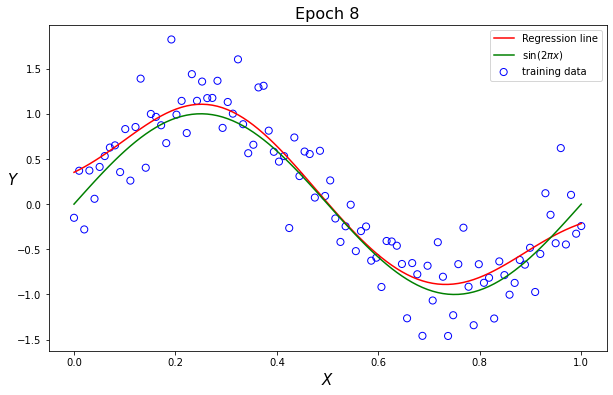

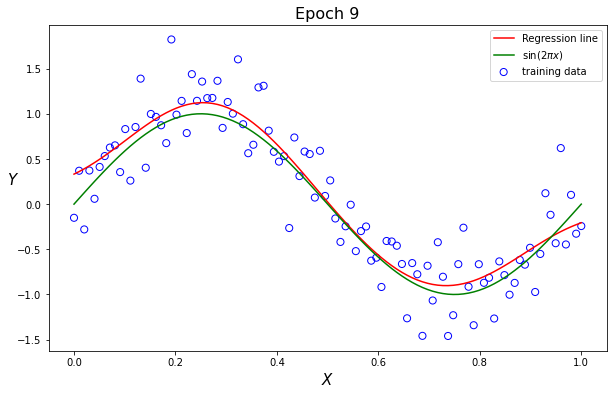

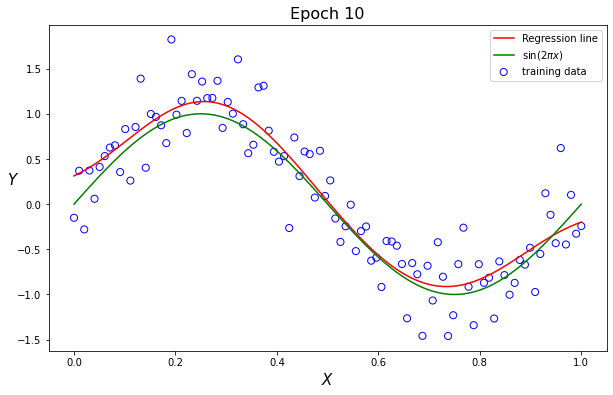

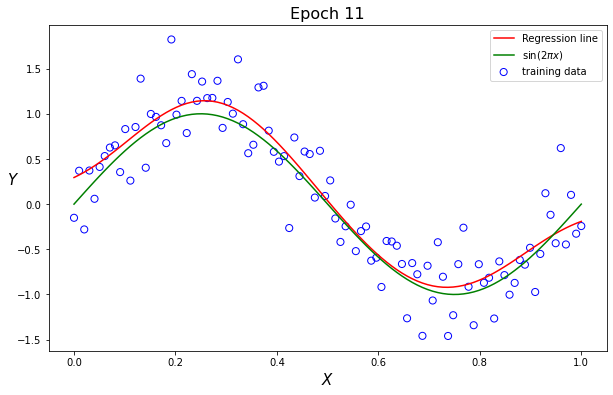

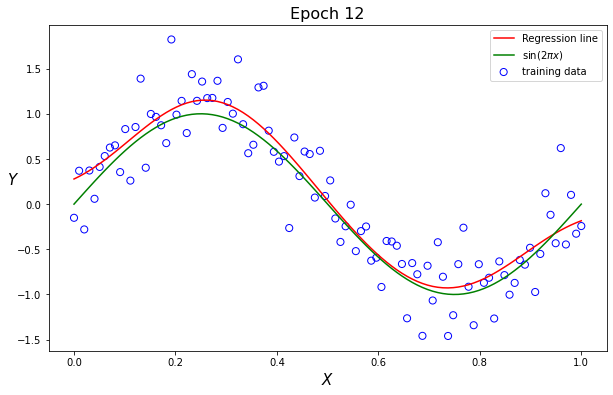

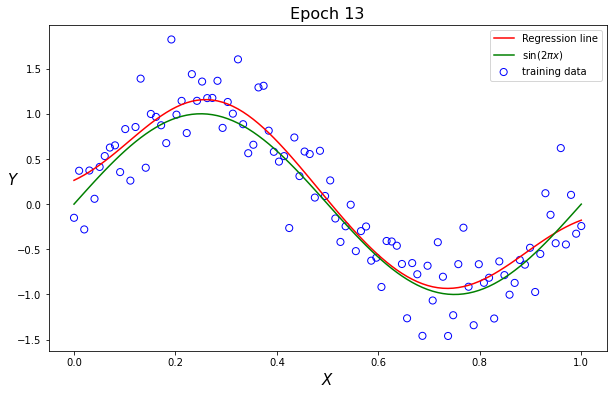

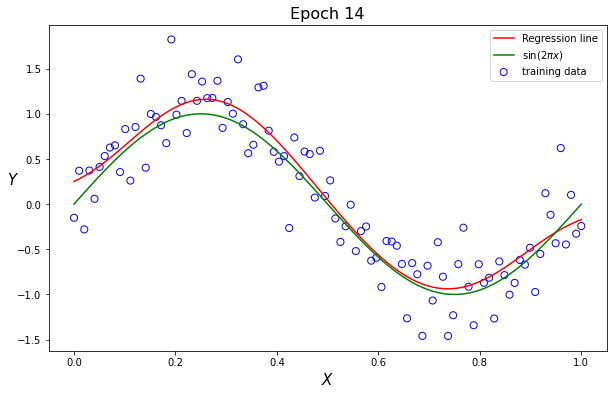

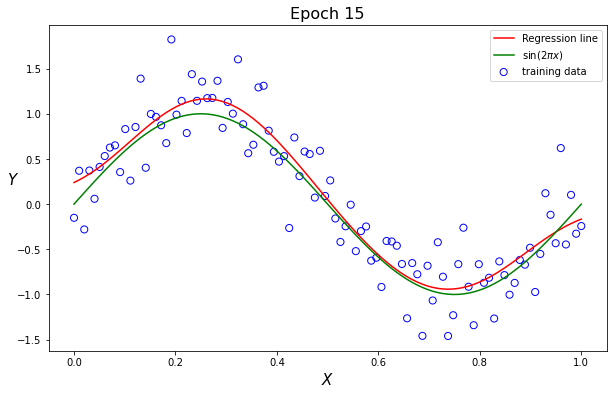

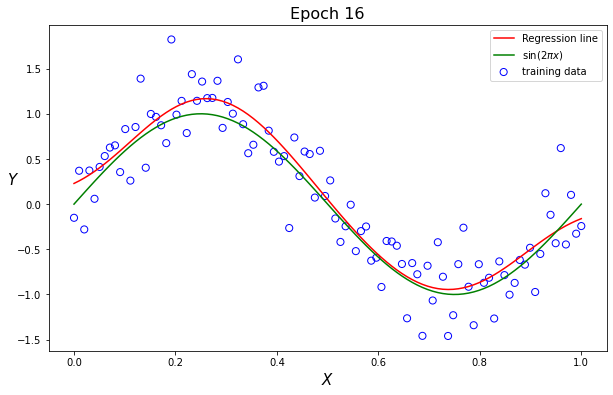

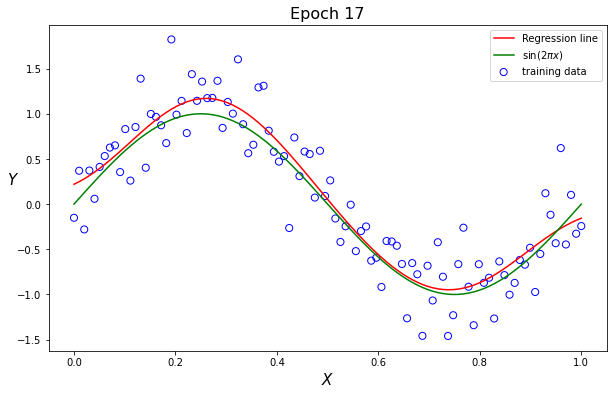

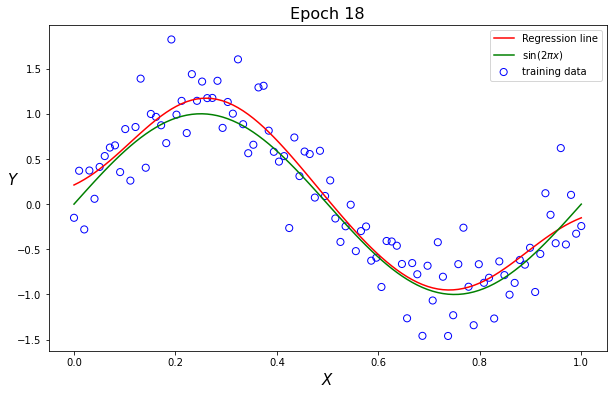

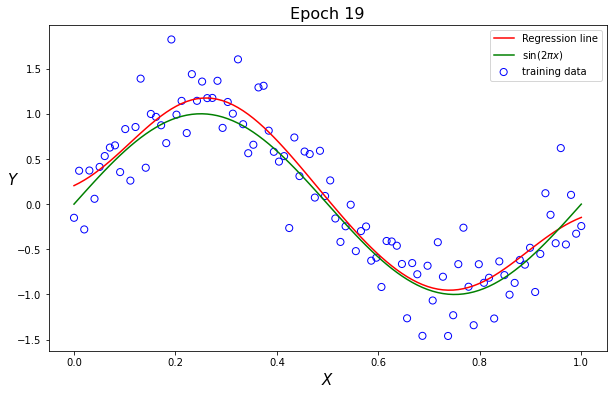

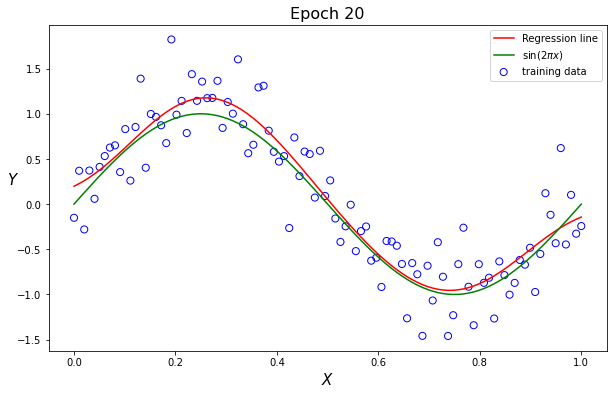

In [6]:
seq_model = Sequential(batch_size=10, num_epochs=20, lr=0.9, transform='Gauss', mu=np.linspace(0, 1, d), s=0.01)
seq_model.fit(X_train, y_train, X_test, y_test)

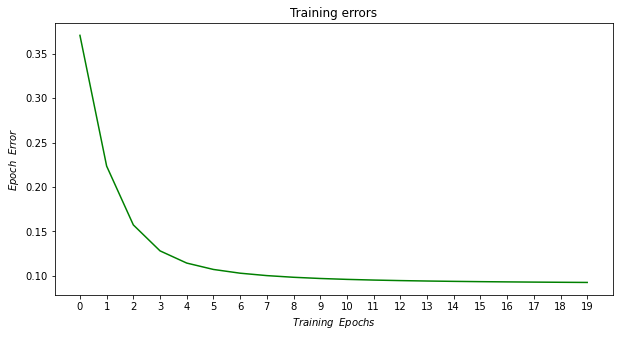

In [7]:
history = seq_model.history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(history)), list(history.values()), 'r', c="g")
ax.set_title('Training errors')
ax.set_xticks(range(len(history)))
ax.set_xlabel('$Training\;\;Epochs$')
ax.set_ylabel('$Epoch\;\;Error$');